# Digit Recognizer
## I will be using Tensorflow to create a neural network that learns to understand numbers

In [1]:
import csv
import cPickle as pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import theano
import theano.tensor as T

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
# Read from csv
data = []
with open("train.csv", "rb") as csvfile:
    trainreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    next(trainreader)
    for row in trainreader:
        data.append(row)
data = np.array(data, dtype=float)

In [3]:
# Normalize data
X = data[:, 1:]
mu = np.mean(X, axis=0)
sigma = np.std(X, axis=0)
data[:, 1:] = np.nan_to_num((X-mu)/sigma)
np.random.shuffle(data)

In [4]:
train = data[:33600]
cv = data[33600:]

In [5]:
nn_input_dim = train[:, 1:].shape[1]
nn_output_dim = 10
num_examples = train.shape[0]

In [6]:
Xvec = T.matrix('X')
yvec = T.lvector('y')
W1 = None
b1 = None
W2 = None
b2 = None

In [7]:
def get_grad(nn_hdim, lmbda, epsilon):
    global W1
    global b1
    global W2
    global b2

    W1 = theano.shared(np.random.randn(nn_input_dim, nn_hdim)/np.sqrt(nn_input_dim), name='W1')
    b1 = theano.shared(np.zeros(nn_hdim), name='b1')
    W2 = theano.shared(np.random.randn(nn_hdim, nn_output_dim)/np.sqrt(nn_hdim), name='W2')
    b2 = theano.shared(np.zeros(nn_output_dim), name='b2')
    
    # Feed-forward propagation
    z1 = Xvec.dot(W1) + b1
    a1 = T.tanh(z1)
    z2 = a1.dot(W2) + b2
    prob = T.nnet.softmax(z2)
    prediction = T.argmax(prob, axis=1)
    
    # Cost Function
    reg_loss = 1./num_examples * lmbda/2 * (T.sum(T.sqr(W1)) + T.sum(T.sqr(W2)))
    loss = T.nnet.categorical_crossentropy(prob, yvec).mean() + reg_loss
    
    # Back Propagation
    dW1 = T.grad(loss, W1)
    db1 = T.grad(loss, b1)
    dW2 = T.grad(loss, W2)
    db2 = T.grad(loss, b2)
    
    forward_prop = theano.function([Xvec], prob)
    calculate_loss = theano.function([Xvec, yvec], loss)
    predict = theano.function([Xvec], prediction)

    gradient_step = theano.function(
        [Xvec, yvec], loss,
        updates=((W2, W2 - epsilon * dW2),
                 (W1, W1 - epsilon * dW1),
                 (b2, b2 - epsilon * db2),
                 (b1, b1 - epsilon * db1)))
    return calculate_loss, gradient_step

## Train function

In [8]:
Xcv, ycv = cv[:, 1:], cv[:, 0]

def train_func(num_examples, calculate_loss, gradient_step, nn_hdim, printint, it, printloss):
    global W1
    global b1
    global W2
    global b2

    W1 = theano.shared(np.random.randn(nn_input_dim, nn_hdim)/np.sqrt(nn_input_dim), name='W1')
    b1 = theano.shared(np.zeros(nn_hdim), name='b1')
    W2 = theano.shared(np.random.randn(nn_hdim, nn_output_dim)/np.sqrt(nn_hdim), name='W2')
    b2 = theano.shared(np.zeros(nn_output_dim), name='b2')
    
    Xtrain, ytrain = train[:num_examples, 1:], train[:num_examples, 0]        
    
    if num_examples == 0:
        if printloss: print("Number of examples: %d\nIteration #: %d\nTraining Cost: %f\n" % (num_examples, 0, 0.0))
        return 0, calculate_loss(Xcv, np.array(ycv, dtype=int))
    
    for i in range(it):
        train_cost = gradient_step(Xtrain, np.array(ytrain, dtype=int))
        
        if printloss and (i+1)%printint == 0:
            print("Number of examples: %d\nIteration #: %d\nTraining Cost: %f\n" % (num_examples, i+1, train_cost))

        cv_cost = calculate_loss(Xcv, np.array(ycv, dtype=int))
    return train_cost, cv_cost

In [9]:
def show_learning(calculate_loss, gradient_step, nn_hdim, pfile=None, it=5000, printloss=False, printint=1000):
    global W1
    global b1
    global W2
    global b2

    if pfile and os.path.isfile(pfile):
        with open(pfile, "rb") as f:
            data = pickle.load(f)
            W1 = data["W1"]
            b1 = data["b1"]
            W2 = data["W2"]
            b2 = data["b2"]
            m_list = data["m"]
            train_cost_list = data["train_cost"]
            cv_cost_list = data["cv_cost"]
    else:
        m_list = []
        train_cost_list = []
        cv_cost_list = []

        for i in range(0, train.shape[0], 1000):
            train_cost, cv_cost = train_func(i, calculate_loss, gradient_step, nn_hdim, printint, it, printloss)
            m_list.append(i)
            train_cost_list.append(train_cost)
            cv_cost_list.append(cv_cost)

        with open(pfile, "wb") as f:
            data = {"W1": W1.get_value(), "b1": b1.get_value(), "W2": W2.get_value(), "b2": b2.get_value(), 
                    "m": m_list, "train_cost": train_cost_list, "cv_cost": cv_cost_list}
            pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
    
    plt.xlabel("m")
    plt.ylabel("Cost")
    plt.plot(m_list, train_cost_list, c="r", label="Training Cost")
    plt.plot(m_list, cv_cost_list, c="g", label="Cross Validation Cost")
    plt.legend(loc='upper center', shadow=True)
    plt.show()

### Run #1 with the following parameters:

In [10]:
nn_hdim = 3
lmbda = 0.5
epsilon = 0.5

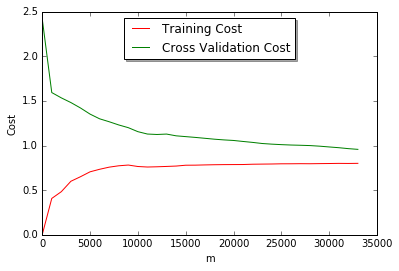

In [11]:
calculate_loss, gradient_step = get_grad(nn_hdim, lmbda, epsilon)
show_learning(calculate_loss, gradient_step, nn_hdim, pfile="first.pickle", it=500)

### Run #2 with the following parameters:

In [12]:
nn_hdim = 5
lmbda = 0.5
epsilon = 0.5

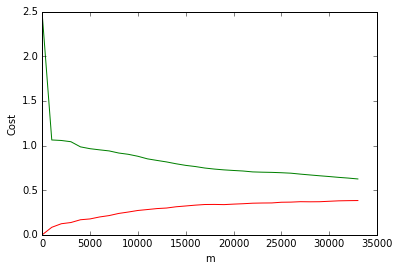

In [13]:
calculate_loss, gradient_step = get_grad(nn_hdim, lmbda, epsilon)
show_learning(calculate_loss, gradient_step, nn_hdim, pfile="second.pickle", it=500)